# Examine Bias when Network is NOT Modeled

In [ ]:
#!pip install linearmodels

In [ ]:
import numpy as np
import statsmodels.api as sm
import xgboost as xgb
from linearmodels.iv import IV2SLS
from sklearn.kernel_ridge import KernelRidge
from scipy.linalg import orth
from scipy.spatial import distance_matrix
from scipy.optimize import leastsq,minimize
import matplotlib.pyplot as plt
import seaborn as sns


np.random.seed(10000)

# Draw some means for each feature
means = np.random.uniform(-10,10,4)

V = 500
covariate_obs = np.column_stack((np.random.normal(means[0],1,V),
                         np.random.normal(means[1],1,V),
                         np.random.normal(means[2],1,V)))

covariate_unobs = np.random.normal(means[3],1,V)
graph_info = np.column_stack((covariate_obs[:,1:3],covariate_unobs))
dist_mat = distance_matrix(graph_info,graph_info)

A = (dist_mat<0.4).astype(int)

# Set the main diagonal to 0's
np.fill_diagonal(A,0)

T = np.random.choice([0,1],V,p=[0.5,0.5])
eps = np.random.normal(0,0.1,V)

# l-2 distance matrix (assumed known)
location = np.random.normal(0,3,V).reshape(V,1)
D = distance_matrix(location,location) # graph weights

# Weighted adjacency matrix
A_weighted = np.multiply(A,D)
B_weighted = np.diag(np.sum(A_weighted,1)**(0.5))
for i in range(V):
    if B_weighted[i,i] ==0:
        next
    else:
        B_weighted[i,i] = 1/B_weighted[i,i]

# Normalized A_weighted
G_weighted = B_weighted@A_weighted@B_weighted

## DGP:
$$Y=\beta GY+f(X)\odot Z+ϵ$$
Outcomes are generated with reduced-form:
$$Y=(I-\beta G)^{-1}(f(X)\odot Z+\epsilon)$$

In [ ]:
beta0 = 0.4666
treated = np.where(T==1)[0]
control = np.where(T==0)[0]
sigma = 0.5 # Kernel bandwidth
lam = 0.001 # kernel regularization term

beta_hat = 0.2 # must be in (-1,1)
parameters = [beta_hat]

# Generate 1 covariate
X = np.random.normal(3,1,V)

# Heterogeneous (incremental) direct effect: fx #
fx = np.maximum(X-2,1-2*X-X**2)+np.sin(0.5*X**2)+np.piecewise(X, [X<1,X>=2,X>=4], [-1,5,1])
#fx = 3*X-0.5*X**2
fxZ = np.multiply(fx,T)

### Generate outcomes using reduced-form ###
IbG = np.linalg.matrix_power((np.diag(np.ones(V))-beta0*A_weighted),-1) #$$$$$$$$$$$$$$$ A<=>G_weighted
Y = IbG@(fxZ+eps)

Summary Statistics for Y:
Mean: -0.4894844021481004
Standard Deviation: 13.973504749832438
Minimum: -178.9273613119691
Maximum: 54.444809427014974
Median: 0.0023147598569782084


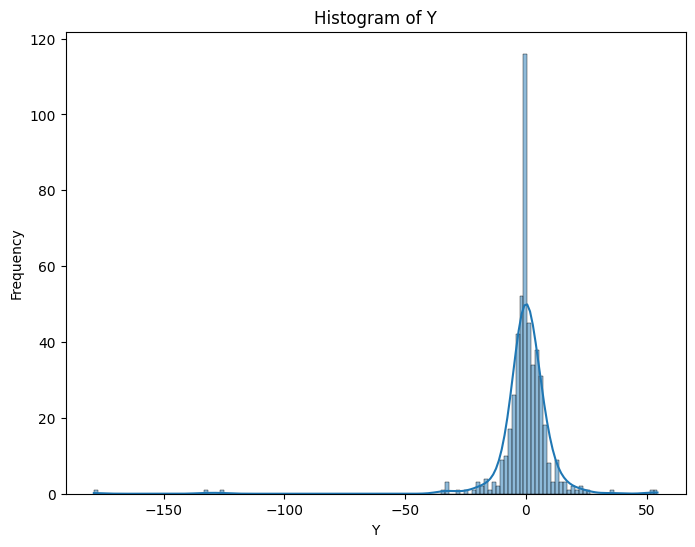

In [ ]:
# Calculate summary statistics
mean_y = np.mean(Y)
std_y = np.std(Y)
min_y = np.min(Y)
max_y = np.max(Y)
median_y = np.median(Y)

print(f"Summary Statistics for Y:")
print(f"Mean: {mean_y}")
print(f"Standard Deviation: {std_y}")
print(f"Minimum: {min_y}")
print(f"Maximum: {max_y}")
print(f"Median: {median_y}")

# Plot the histogram
plt.figure(figsize=(8, 6))
sns.histplot(Y, kde=True)  # Include KDE for smoother distribution visualization
plt.title("Histogram of Y")
plt.xlabel("Y")
plt.ylabel("Frequency")
plt.show()

Summary Statistics for X when T=1:
Mean: 3.0405280795293046
Standard Deviation: 0.9554896356074054
Minimum: -0.30057337415316887
Maximum: 5.855247467914209
Median: 3.0832203309572446


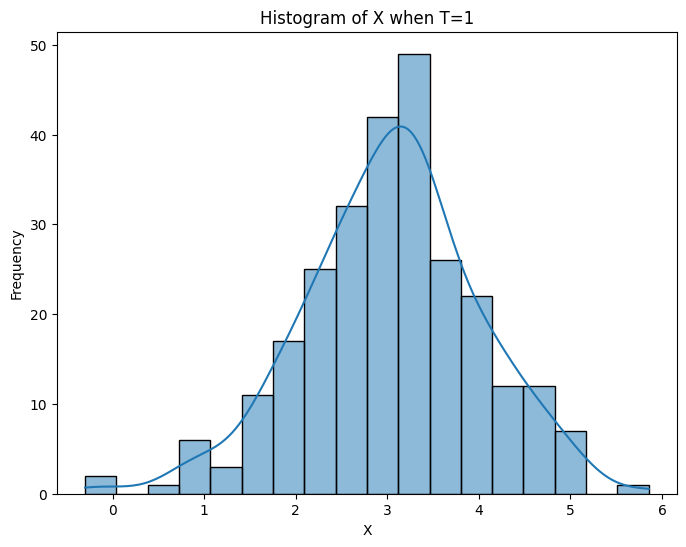

In [ ]:
# Filter data where T == 1
X_treated = X[T == 1]

# Calculate summary statistics for X where T == 1
mean_x_treated = np.mean(X_treated)
std_x_treated = np.std(X_treated)
min_x_treated = np.min(X_treated)
max_x_treated = np.max(X_treated)
median_x_treated = np.median(X_treated)

print(f"Summary Statistics for X when T=1:")
print(f"Mean: {mean_x_treated}")
print(f"Standard Deviation: {std_x_treated}")
print(f"Minimum: {min_x_treated}")
print(f"Maximum: {max_x_treated}")
print(f"Median: {median_x_treated}")

# Plot the histogram for X when T=1
plt.figure(figsize=(8, 6))
sns.histplot(X_treated, kde=True)  # Include KDE for smoother distribution visualization
plt.title("Histogram of X when T=1")
plt.xlabel("X")
plt.ylabel("Frequency")
plt.show()


# Approach 1. Ignore peer effects and directly fit
We include a baseline $f_0$ to account for the non-zero outcomes for the controlled individuals. The model is given by
$$Y_i=f_0(X_i)+f_1(X_i)\cdot Z_i+ϵ_i$$

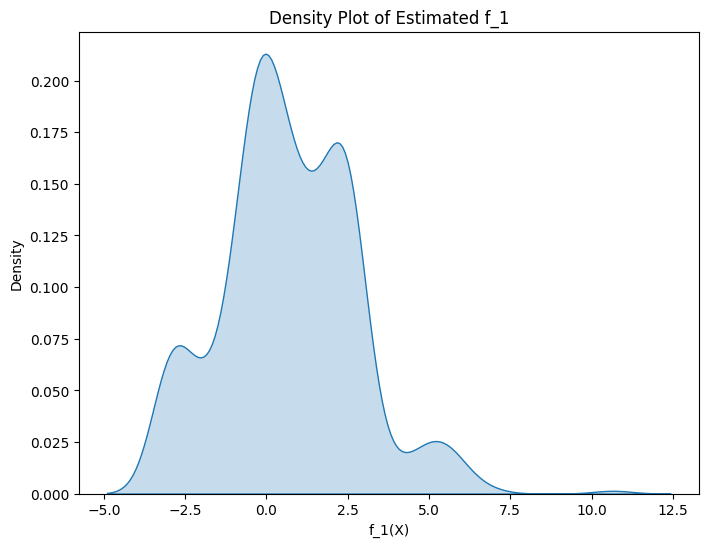

In [ ]:
# Prepare the data
X_reshaped = X.reshape(-1, 1)
T_reshaped = T.reshape(-1, 1)

# Fit Kernel Ridge Regression for f_0
kr_f0 = KernelRidge(kernel='rbf', gamma=10) ######### Tuning ##########
kr_f0.fit(X_reshaped[T == 0], Y[T == 0])  # Fit only on control group data
f0_pred = kr_f0.predict(X_reshaped)

# Fit Kernel Ridge Regression for f_1
kr_f1 = KernelRidge(kernel='rbf', gamma=2)  ######## Tuning ##########
kr_f1.fit(X_reshaped[T==1], Y[T==1]-f0_pred[T==1]) # Fit on treated group residuals
f1_pred = kr_f1.predict(X_reshaped)

# Density plot of f_1
plt.figure(figsize=(8, 6))
sns.kdeplot(f1_pred, fill=True)
plt.title("Density Plot of Estimated f_1")
plt.xlabel("f_1(X)")
plt.ylabel("Density")
plt.show()

# Approach 2. Full semiparametric IV-RKHS regression

In [ ]:
iteration = 1
K = np.exp(-distance_matrix(X[treated].reshape(int(sum(T)),1),X[treated].reshape(int(sum(T)),1))**2/(2*sigma**2))
rsq = 1

while True:
    Y_tilde = Y-beta_hat*A_weighted@Y
    C_hat = np.linalg.matrix_power(lam*np.diag(np.ones(int(sum(T))))+K,-1)@Y_tilde[treated]
    KC = K@C_hat

    rsq_new = 1-np.dot(fxZ[treated]-KC,fxZ[treated]-KC)/np.dot(fxZ[treated]-np.mean(fxZ[treated]),fxZ[treated]-np.mean(fxZ[treated]))

    fx_hat = np.zeros(V)
    fx_hat[treated] = KC

    q = 5
    iv1 = np.array([np.linalg.matrix_power(A_weighted,(k+2))@np.multiply(fx_hat,T) for k in range(q)]).T

    ivreg = IV2SLS(
        dependent = Y-fx_hat, # dependent variable
        exog = None, # exogenous regressors
        endog = A_weighted@Y, # endogenous regressors
        instruments = iv1, # instrumental variables
        weights = None).fit(cov_type="unadjusted")

    beta_hat = ivreg.params.iloc[0]
    parameters = np.column_stack((parameters,ivreg.params))
    iteration += 1

    if abs(rsq_new-rsq)<0.0000001:
        print('R-squared:',round(rsq_new,4))
        print("Estimation converged")
        break
    rsq = rsq_new

R-squared: 0.9475
Estimation converged


# Compare $\hat{f_1}$ under approach 1 and $\hat{f}$ under approach 2

1. Density plots

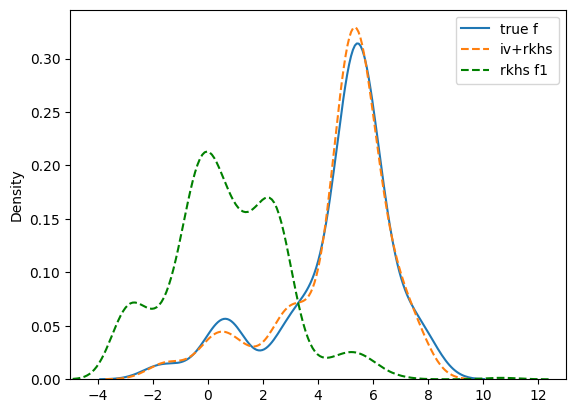

In [ ]:
sns.kdeplot(fx[treated],label='true f')
sns.kdeplot(fx_hat[treated],label='iv+rkhs',linestyle='--')
sns.kdeplot(f1_pred,color='g',label='rkhs f1',linestyle='--')
plt.xlim(-5, 13)
plt.legend(loc=1)

2. Function plots

$f(x) = \max\{X-2,1-2X-X^2\}+\sin(0.5X^2)+piecewise(X, [X<1,X>=2,X>=4], [-1,5,1])$

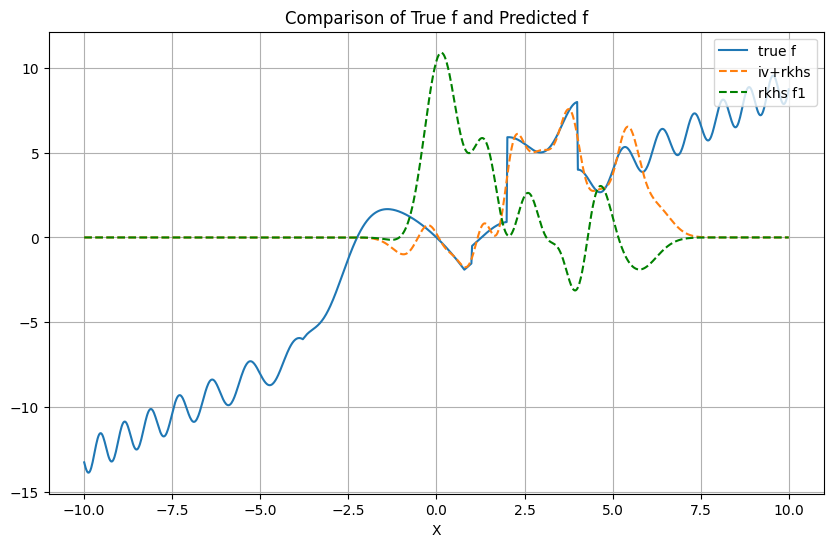

In [ ]:
# Generate a grid of 1000 X values
x_grid = np.linspace(-10, 10, 1000)

# Evaluate the grid on f(x)
f_x_grid = np.maximum(x_grid - 2, 1 - 2 * x_grid - x_grid**2) + np.sin(0.5 * x_grid**2) + np.piecewise(x_grid, [x_grid < 1, x_grid >= 2, x_grid >= 4], [-1, 5, 1])

# Evaluate the grid on f1 from the kernel ridge regression
x_grid_reshaped = x_grid.reshape(-1, 1)
f1_grid = kr_f1.predict(x_grid_reshaped)

# Predict f using the iv+rkhs
f_hat = np.zeros(1000)
for i in range(1000):
    f_hat[i] = np.exp(-(x_grid[i]-X[treated])**2/2/sigma**2)@C_hat

plt.figure(figsize=(10, 6))
plt.plot(x_grid, f_x_grid, label='true f')
plt.plot(x_grid, f_hat, label='iv+rkhs',linestyle='--')
plt.plot(x_grid, f1_grid,color='g',label='rkhs f1',linestyle='--')
plt.xlabel('X')
plt.ylabel('')
plt.title('Comparison of True f and Predicted f')
plt.legend(loc=1)
plt.grid(True)
plt.show()

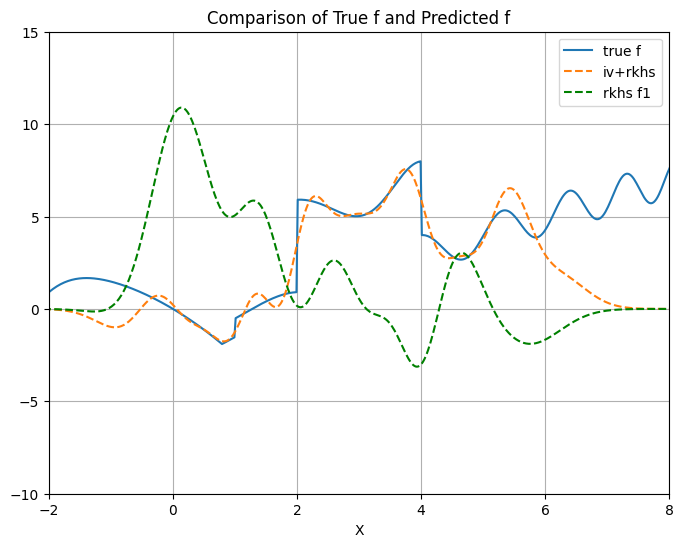

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(x_grid, f_x_grid, label='true f')
plt.plot(x_grid, f_hat, label='iv+rkhs',linestyle='--')
plt.plot(x_grid, f1_grid,color='g',label='rkhs f1',linestyle='--')
plt.xlabel('X')
plt.ylabel('')
plt.title('Comparison of True f and Predicted f')
plt.legend(loc=1)
plt.grid(True)
plt.xlim(-2, 8)
plt.ylim(-10, 15)
plt.show()